# Making Kaggle Directory and Downloading Dataset

Here we download the Data Using the Kaggle API Command and unzip the file that is downloaded into our working directory 

In [ ]:
"""Downloading and extracting the data from Kaggle"""

#!pip install kaggle #requirement already satisfied so you can skip it next time

#create a .kaggle directory
!mkdir ~/.kaggle

#copy the kaggle json file to the current instance folder
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# #download the dataset
!kaggle datasets download -d adityajn105/flickr8k
# #you could also use ! kaggle datasets download <name-of-dataset> if the dataset is not in any competition competition /c/

# #unzipping the training and testing folders
!unzip flickr8k.zip


# Importing the Dependencies:

*   Tensorflow for Modelling the CNN and LSTM
*   Keras
*   Matplotlib for visualization
*   Numpy for math computation
*   Pandas for data engineering
*   CV2 for image processing
*   String for string manipulation
*   Pickle to store Data from Large Computations





In [ ]:
#Importing the Dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
import matplotlib.image as mpimg
import string
import pickle
from collections import Counter

# Sorting Directories and file paths, Reading captions into dataframes

In [ ]:
root = "/content"
images_path = os.listdir(os.path.join(root, "Images"))
images_folder = os.path.join(root, "Images")
images = glob(os.path.join(root, "Images", "*.jpg"))
print("\nThere are {} images images in the dataset.".format(len(images)))


There are 8091 images images in the dataset.


In [ ]:
dataset_df = pd.read_csv("/content/captions.txt")
dataset_df.rename(columns={"image": "Filename", "caption": "Captions"}, inplace=True)
dataset_df.head()

,Filename,Captions
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# Data Visualization and Text Preprocessing

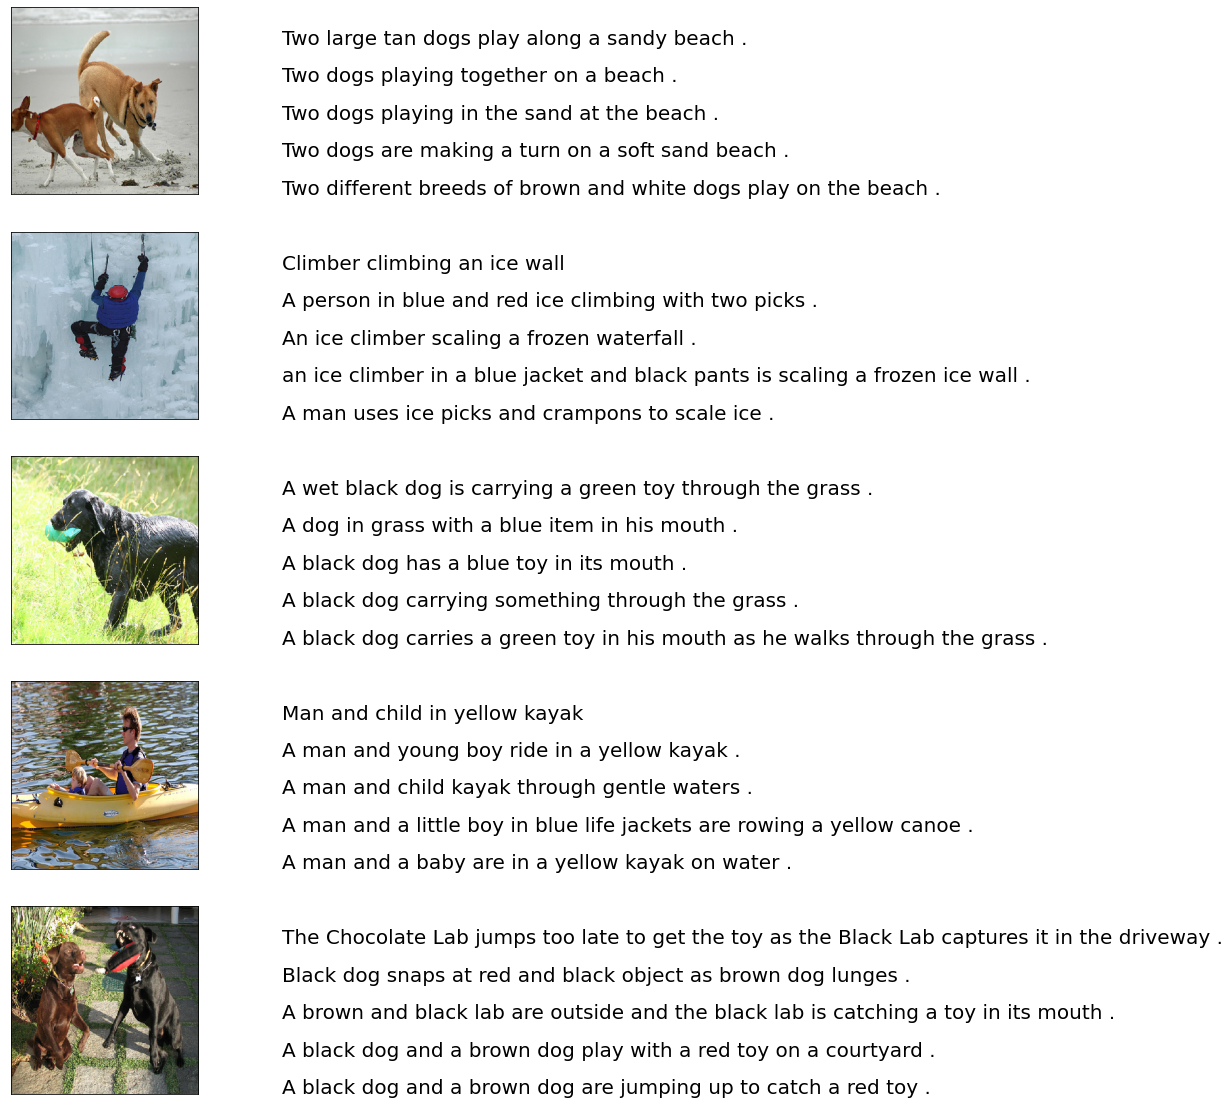

In [ ]:
unique_filenames = np.unique(dataset_df.Filename.values)

from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 299
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for imageID in unique_filenames[npic+15:npic+20]:
    filename = images_folder + '/' + imageID
    captions = list(dataset_df["Captions"].loc[dataset_df["Filename"]==imageID].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
def vocab_summary(dataset_df):
    vocabulary = []
    for sentence in dataset_df.Captions.values:
        vocabulary.extend(sentence.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    count = Counter(vocabulary)
    dfword = pd.DataFrame({"word":count.keys(),"count":count.values()})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

vocab_df = vocab_summary(dataset_df)
vocab_df.head(15)

Vocabulary Size: 9630


,word,count
0,a,40319
1,.,36577
2,A,22667
3,in,18962
4,the,15328
5,on,10730
6,is,9345
7,and,8850
8,dog,7984
9,with,7760


In [ ]:
import string
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))  
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


In [ ]:
dataset_df["Captions"] = dataset_df["Captions"].map(lambda x: text_clean(x))
dataset_df.head(15) 

,Filename,Captions
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of sta...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden c...
5,1001773457_577c3a7d70.jpg,black dog and spotted dog are fighting
6,1001773457_577c3a7d70.jpg,black dog and tricolored dog playing with eac...
7,1001773457_577c3a7d70.jpg,black dog and white dog with brown spots are ...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each ...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other


In [ ]:
new_vocab_df = vocab_summary(dataset_df)
new_vocab_df.head(15)

Vocabulary Size: 9473


,word,count
0,in,18962
1,the,15328
2,on,10730
3,is,9345
4,and,8850
5,dog,7984
6,with,7760
7,man,6829
8,of,6712
9,Two,4365


Generating a dictionary to store all the image data and captions

In [ ]:
def dict_gen(df):
  data_dict = {}
  for filename in list(dataset_df.Filename.unique()):
    data_dict[filename] = list(dataset_df[dataset_df["Filename"] == filename]["Captions"])
  return data_dict

In [ ]:
image_caption_data = dict_gen(dataset_df)
print("The dictionary has record of {} images".format(len(image_caption_data.keys())))

print("\nFor example, image with imageID {} has the following captions: {} ".format(list(image_caption_data.keys())[5], image_caption_data[list(image_caption_data.keys())[5]]))

The dictionary has record of 8091 images

For example, image with imageID 1007320043_627395c3d8.jpg has the following captions: [' child playing on rope net', ' little girl climbing on red roping', ' little girl in pink climbs rope bridge at the park', ' small child grips onto the red ropes at the playground', ' The small child climbs on red ropes on playground'] 


In [ ]:
# Finding the set of words in the text file
def vocab(clean_data):
  all_words = set()
  for image_ID in clean_data.keys():
    [all_words.update(sentence.split()) for sentence in clean_data[image_ID]]
  return all_words

dataset_vocabulary = vocab(image_caption_data)
print("There are {} different words in the dataset".format(len(dataset_vocabulary)))

There are 9473 different words in the dataset


Saving the entire vocabulary to a text file

In [ ]:
def save_dict(clean_data, filename):
    lines = list()
    for image_ID, caption in clean_data.items():
        for desc in caption:
            lines.append(image_ID + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(image_caption_data, 'captions1.txt')

# Image Preprocessing

In [ ]:
# Image Preprocessing
def preprocess(image_path):
    # The InceptionV3 model input image size is 299x299
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert the image to a 3D array
    img_array = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension to the image array
    img_array = np.expand_dims(img_array, axis=0)
    # Pre-Processing the final input array
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    
    return img_array 

In [ ]:
# We can load the InceptionV3 model pre-trained on the imagenet dataset
input_model = InceptionV3(weights='imagenet')

# Remove the last layer
model = Model(input_model.input, input_model.layers[-2].output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Generating the vector representations of the images using the pre-trained model

In [ ]:
# Encoding the image and reshaping it into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    feature_vector = model.predict(image) # Get the encoding vector for the image
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1]) # reshape from (1, 2048) to (2048, )
    return feature_vector
    
encoding = {}

for i in tqdm(images):
  name = i.split("/")[3]
  encoding[name] = encode(i)
    


# Save the features in the images1 pickle file
with open("images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding, encoded_pickle)

100%|██████████| 8091/8091 [08:05<00:00, 16.67it/s]


In [ ]:
# Generating a  list of the training captions

all_training_captions = []

for image_ID, captions in image_caption_data.items():
    for sentence in captions:
        all_training_captions.append(sentence)
        
print("Our dataset contains {} captions.".format(len(all_training_captions)))


# Consider only words which occur at least 10 times in the whole text

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_training_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and vice versa.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files

with open("words_to_index.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)
    
with open("index_to_words.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)
    
#convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(image_caption_data)
print('Maximum Sequence Length: %d' % max_length)

Our dataset contains 40455 captions.
preprocessed words 9474 -> 1989
Maximum Sequence Length: 32


# Building the data generator

In [ ]:
# data generator

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

# Extracting already existing word embeddings

In [ ]:
# Download, install, and then Load the Glove vectors
# https://github.com/stanfordnlp/GloVe

embeddings_index = {} # empty dictionary
f = open('/content/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

Found 380613 word vectors.


(1990, 200)

# Building the Model

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 200)      398000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

# Training the Model

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 15
number_pics_per_bath = 3
steps = len(image_caption_data)//number_pics_per_bath

features = pickle.load(open("images1.pkl", "rb"))

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

#tf.config.run_functions_eagerly(True)

# for i in range(epochs):
#     generator = data_generator(clean_data, features, wordtoix, max_length, number_pics_per_bath)
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('model_' + str(i) + '.h5')

generator = data_generator(image_caption_data, features, wordtoix, max_length, number_pics_per_bath)
training_hist = model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=1)
model.save('image_capioning_model.h5')

Epoch 1/10
2697/2697 [==============================] - 186s 68ms/step - loss: 4.3801
Epoch 2/10
2697/2697 [==============================] - 179s 66ms/step - loss: 3.6537
Epoch 3/10
2697/2697 [==============================] - 177s 66ms/step - loss: 3.4408
Epoch 4/10
2697/2697 [==============================] - 181s 67ms/step - loss: 3.3135
Epoch 5/10
2697/2697 [==============================] - 181s 67ms/step - loss: 3.2246
Epoch 6/10
2697/2697 [==============================] - 175s 65ms/step - loss: 3.1601
Epoch 7/10
2697/2697 [==============================] - 177s 65ms/step - loss: 3.1107
Epoch 8/10
2697/2697 [==============================] - 175s 65ms/step - loss: 3.0695
Epoch 9/10
2697/2697 [==============================] - 174s 64ms/step - loss: 3.0351
Epoch 10/10
2697/2697 [==============================] - 174s 65ms/step - loss: 3.0058


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


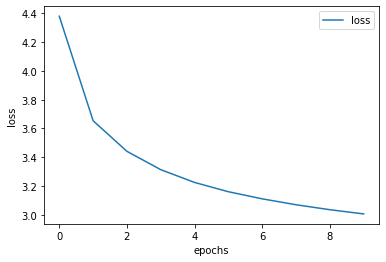

In [ ]:
for label in ["loss"]:
    plt.plot(training_hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()